In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

In [2]:
data = pd.read_csv('data/spinitial.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377 entries, 0 to 2376
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Date                                    2377 non-null   object 
 1   previous_open                           2376 non-null   float64
 2   previous_high                           2376 non-null   float64
 3   previous_low                            2376 non-null   float64
 4   previous_close                          2376 non-null   float64
 5   2_weeks_ago_close                       2375 non-null   float64
 6   previous_volume                         2376 non-null   float64
 7   previous_return                         2375 non-null   float64
 8   following_week_close                    2377 non-null   float64
 9   following_week_return                   2377 non-null   object 
 10  jobless_claims                          2377 non-null   int6

In [4]:
data = data.drop('week_of_month',axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377 entries, 0 to 2376
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Date                                    2377 non-null   object 
 1   previous_open                           2376 non-null   float64
 2   previous_high                           2376 non-null   float64
 3   previous_low                            2376 non-null   float64
 4   previous_close                          2376 non-null   float64
 5   2_weeks_ago_close                       2375 non-null   float64
 6   previous_volume                         2376 non-null   float64
 7   previous_return                         2375 non-null   float64
 8   following_week_close                    2377 non-null   float64
 9   following_week_return                   2377 non-null   object 
 10  jobless_claims                          2377 non-null   int6

In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data['month'] = data['Date'].dt.month
data= data.dropna()

In [7]:
data['previous_return']=data['previous_return'].astype(float)
data['following_week_return']=data['following_week_return'].astype(float)
data['4_week_rolling_std dev']=data['4_week_rolling_std dev'].astype(float)
data['13_week_rolling_std dev']=data['13_week_rolling_std dev'].astype(float)
data['26_week_rolling_std dev']=data['26_week_rolling_std dev'].astype(float)
data['40_week_rolling_std_dev']=data['40_week_rolling_std_dev'].astype(float)
data['52_week_rolling_std_dev']=data['52_week_rolling_std_dev'].astype(float)
data.info()
data2 = data

<class 'pandas.core.frame.DataFrame'>
Index: 2277 entries, 100 to 2376
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Date                                    2277 non-null   datetime64[ns]
 1   previous_open                           2277 non-null   float64       
 2   previous_high                           2277 non-null   float64       
 3   previous_low                            2277 non-null   float64       
 4   previous_close                          2277 non-null   float64       
 5   2_weeks_ago_close                       2277 non-null   float64       
 6   previous_volume                         2277 non-null   float64       
 7   previous_return                         2277 non-null   float64       
 8   following_week_close                    2277 non-null   float64       
 9   following_week_return                   2277 non-null  

Text(0, 0.5, 'Weekly Closing Price ($)')

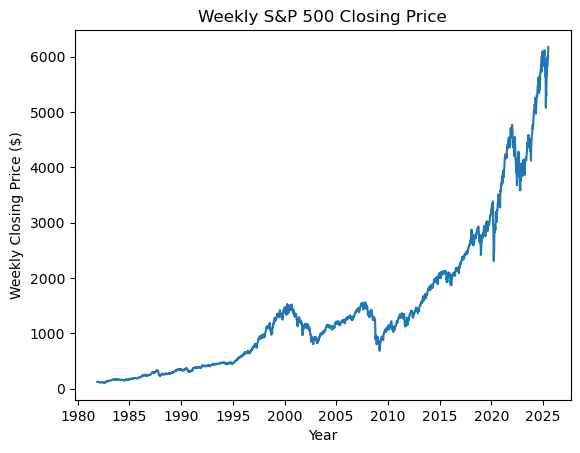

In [8]:
#This plot shows the weekly closing price of the S&P500 since 1982
plt.plot(data['Date'],data['previous_close'])
plt.title('Weekly S&P 500 Closing Price')
plt.xlabel('Year')
plt.ylabel('Weekly Closing Price ($)')

Text(0, 0.5, 'Weekly Return (%)')

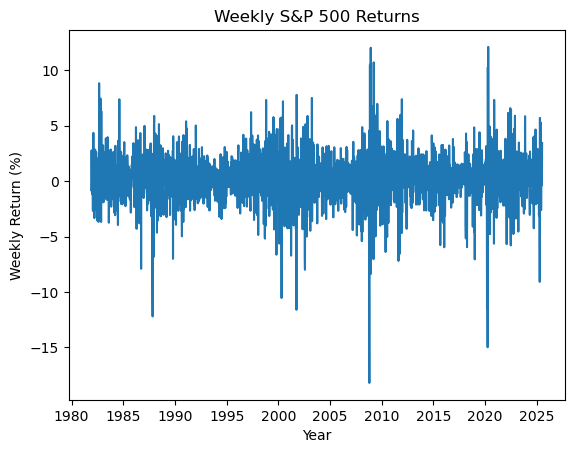

In [9]:
#This plot shows the weekly returns of the S&P500 in %
plt.plot(data['Date'],data['previous_return'])
plt.title('Weekly S&P 500 Returns')
plt.xlabel('Year')
plt.ylabel('Weekly Return (%)')

In [10]:
data.dropna()
X=data.drop(['following_week_close','following_week_return','month','Date'],axis=1)
y=data['following_week_close']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [12]:
numerical=['previous_open','previous_high','previous_low','previous_close','2_weeks_ago_close','previous_volume','previous_return','52_week_ma','40_week_ma','26_week_MA','13_week_ma','8_week_MA','4_week_MA','100_week_ma','previos_week_30_year_constant_maturity','previos_week_7_year_constant_maturity','previos_week_2_year_constant_maturity','jobless_claims','100_week_ma','4_week_rolling_std dev','13_week_rolling_std dev','26_week_rolling_std dev','40_week_rolling_std_dev','52_week_rolling_std_dev']

In [13]:
polytransformer = Pipeline([         
                                    ('imputer',SimpleImputer(strategy='mean')),
                                    ('poly',PolynomialFeatures(degree = 3,include_bias=False)),
                                    ('scale',StandardScaler())
                                ])
transformer = [('polynomialtransformations',polytransformer,numerical)]
transform = ColumnTransformer(transformers = transformer,remainder='passthrough')

In [14]:
#The below code replaces all outliers with NAN Values
import pandas as pd
import numpy as np
def replace_outliers_multi_column(df, columns):
  df_copy = df.copy()
  for column in columns:
    # Calculate Q1, Q3, and IQR for the current column
    q1 = df_copy[column].quantile(0.25)
    q3 = df_copy[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Identify and replace outliers
    df_copy.loc[
        (df_copy[column] < lower_bound) | (df_copy[column] > upper_bound),
        column
    ] = np.nan
  return df_copy


In [15]:
#This replaces outliers with nan values

columns_to_clean = ['52_week_ma','40_week_ma','26_week_MA','13_week_ma','8_week_MA','4_week_MA','100_week_ma','previos_week_30_year_constant_maturity','previos_week_7_year_constant_maturity','previos_week_2_year_constant_maturity','jobless_claims','100_week_ma','4_week_rolling_std dev','13_week_rolling_std dev','26_week_rolling_std dev','40_week_rolling_std_dev','52_week_rolling_std_dev']
clean_training = replace_outliers_multi_column(X_train, columns_to_clean)
X_train = clean_training

In [16]:
initialpipe = Pipeline([
    ('transform',transform),
    ('reg',LinearRegression())
])


In [17]:
baselinemodel = initialpipe.fit(X_train,y_train)

In [18]:
preds = baselinemodel.predict(X_test)
baselineerror = mean_squared_error(preds,y_test)

In [19]:
# BELOW IS THE RMSE OF OUR INITIAL FUNCTION 
print(f"The baseline RMSE is: {np.sqrt(baselineerror)}")

The baseline RMSE is: 10663.773946011897
